# 🎨 AI 藝術辨識專案：使用 CNN 模型判別畫家

本專案目標是透過卷積神經網路（CNN）模型訓練，來辨識畫作的創作者，解決來自《Best Artworks of All Time》資料集中 50 位畫家的多類別分類問題。

---

## 📌 專案目標

- 輸入一張畫作圖片，自動判斷是出自哪位畫家
- 使用 TensorFlow 自建 CNN 架構進行訓練
- 實作多分類圖像辨識應用

---

## 🖼️ 使用資料集

- 📂 資料來源：[Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
- 包含 50 位世界著名畫家，共數千張畫作
- 每張圖片檔名中包含作者資訊，需自行從檔名前處理出 label
- 分為訓練集 `train_resized/` 和測試集 `test_resized/`

---

## 🧠 使用技術

| 技術 | 說明 |
|------|------|
| Python | 主程式語言 |
| TensorFlow / Keras | CNN 架構實作 |
| Pandas | 資料整理 |
| Matplotlib / Seaborn | 資料與訓練結果視覺化 |
| OpenCV | 圖像讀取與前處理 |

---

## 🏗️ 模型架構

- 使用多層卷積層與 MaxPooling 層進行特徵提取
- Dense 層進行分類（共 50 類）
- 激活函數使用 ReLU、輸出層使用 Softmax
- optimizer：Adam

---

## 📈 訓練成果展示

- 最終測試集準確率（Test Accuracy）：`約 60~80%`（依實際訓練而定）
- 混淆矩陣與分類報表（可加入圖）
- 實測推論功能 `predict_author(img)` ✅

---

## ▶️ 執行方式

1. 安裝套件：

```bash
pip install tensorflow opencv-python pandas matplotlib seaborn


# 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

**訓練一個 CNN 模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**




### 資料集下載

- 資料集說明 :
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊 colab 左側**檔案**來查看

- 下載連結：
  - train: https://drive.google.com/file/d/1K3FRVeabwV7TxboRsrkFcT34tPV9DWqr/view?usp=sharing
  - test: https://drive.google.com/file/d/1GCzWxFrIbb4d1JSXSrt3kRb6uERVqXpx/view?usp=sharing


In [ ]:
import random
import os

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免 IP 被封鎖

if not os.path.isfile("./train.zip"):
    !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
    !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
    !unzip train.zip
    !unzip test.zip
else:
    !echo "檔案已存在"

檔案已存在


## 1. 讀入封包

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

## 2. 取得資料集

- **檢視一下 artist.csv**，重要內容包含:
  - 畫家名稱 (name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有 50 位畫家，意謂著有 50 個 class 要去辨識。

In [ ]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ", num_classes)
artists.head()

Number of artists :  50


id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: ?а?и?...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod m?n?]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [??ne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

* 只取出名字與畫的數量，把名字用下底線連起來

In [ ]:
artists = artists.loc[:, ["name", "paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

name  paintings
0   Amedeo_Modigliani        193
1  Vasiliy_Kandinskiy         88
2        Diego_Rivera         70
3        Claude_Monet         73
4       Rene_Magritte        194

* **計算各個畫家畫作數量**

In [ ]:
sum=0
for number,i in enumerate(os.listdir("train_resized/")):
  sum+=1 ##看一下畫作數量
sum

7520

可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24
{0: 193, 1: 88, 2: 70, 3: 73, 4: 194, 5: 139, 6: 90, 7: 99, 8: 877, 9: 117, 10: 137, 11: 126, 12: 171, 13: 439, 14: 141, 15: 336, 16: 291, 17: 120, 18: 87, 19: 328, 20: 259, 21: 134, 22: 239, 23: 119, 24: 164, 25: 55, 26: 143, 27: 128, 28: 186, 29: 81, 30: 702, 31: 262, 32: 255, 33: 81, 34: 59, 35: 91, 36: 66, 37: 67, 38: 47, 39: 31, 40: 70, 41: 43, 42: 188, 43: 84, 44: 102, 45: 181, 46: 311, 47: 109, 48: 49, 49: 24}
{0: 1.8816380617031219, 1: 2.666991436129801, 2: 2.8958330085586486, 3: 2.8538688094596165, 4: 1.8764700915446793, 5: 2.209854317477316, 6: 2.6445185802777424, 7: 2.5492084004734177, 8: 1.0, 9: 2.382154315810251, 10: 2.2243473247798824, 11: 2.3080463436565295, 12: 2.0026646941053476, 13: 1.0598288375328362, 14: 2.195568360229839, 15: 1.3272170906448033, 16: 1.471004983436515, 17: 2.3568365078259617, 18: 2.6784201319534238, 19: 1.3513146422238638, 20: 1.5875001889084697, 21: 2.2464884506570963, 22: 1.6678646986764967

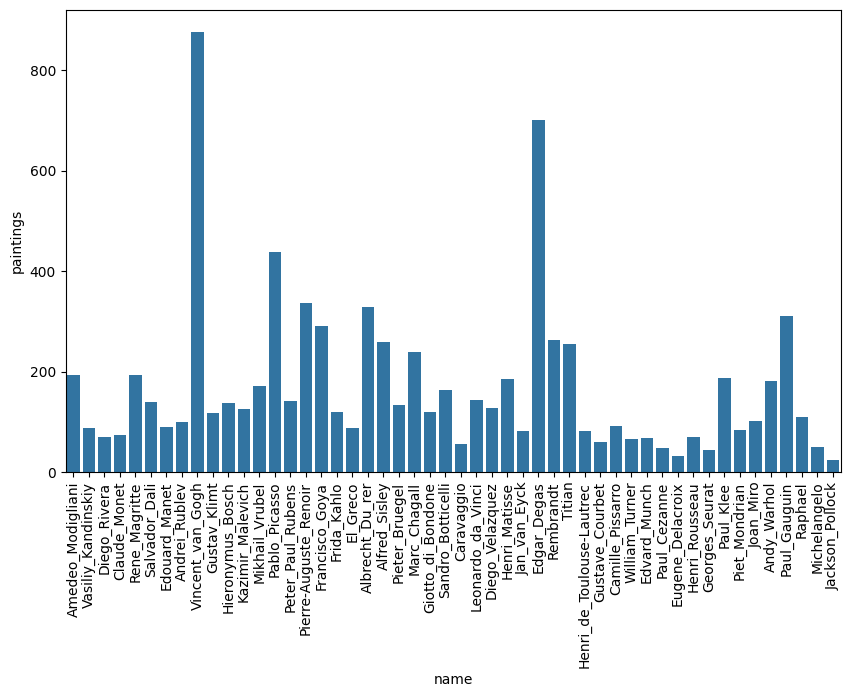

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=artists.name, y=artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)

print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ", artists.paintings.max(), " 最少畫作為 : ", artists.paintings.min())

# class weight
mydict = {}
keys = 0
for i in artists.paintings:
    mydict[keys] = i
    keys += 1

print(mydict)

def create_class_weight(dict1, mu=0.15):
    total = 8446
    keys = dict1.keys()
    class_weight = dict()
    for key in keys:
        score = math.log((mu * total) / float(dict1[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

print(create_class_weight(mydict))


* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7520


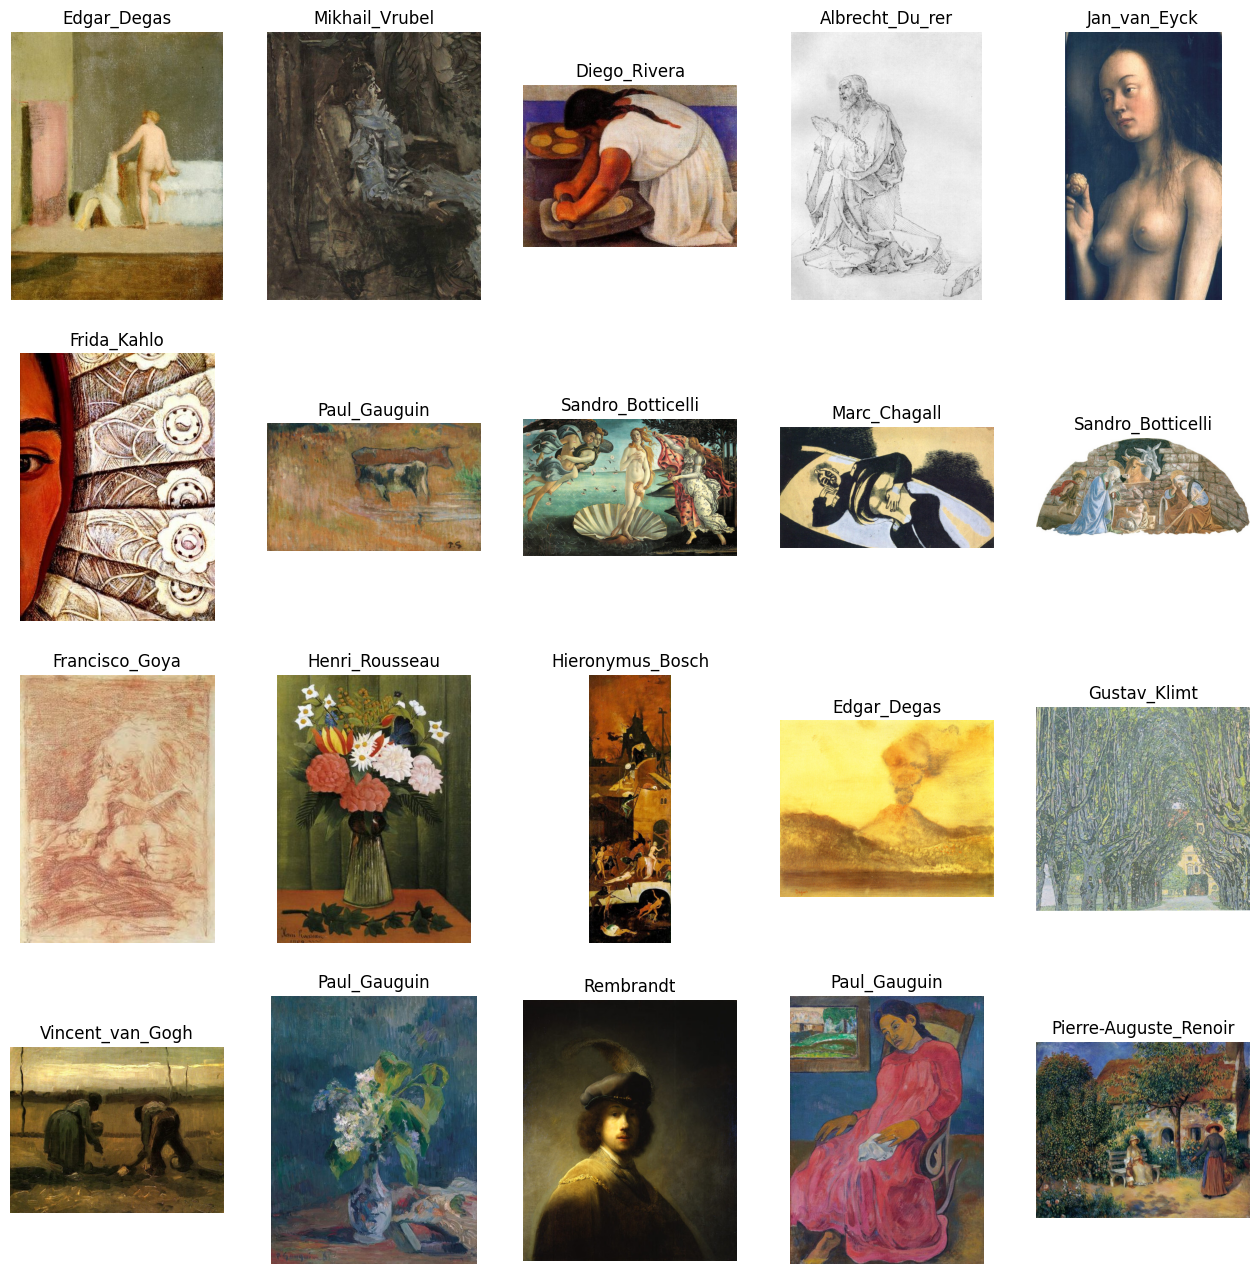

In [ ]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
random_list = random.sample(range(0, total_len), 20)
print("training 畫作總共畫作有 : ", total_len)

show_imgs = [img_list[rand] for rand in random_list]

plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理


In [ ]:
# 將英文映射成數字的dict
def authorName_to_num():
    return {name: idx for idx, name in enumerate(artists.name)}

# 將數字映射成英文的dict
def make_num_to_authorName():
    return {idx: name for idx, name in enumerate(artists.name)}

class_name = authorName_to_num()
rev_class_name = make_num_to_authorName()

print(rev_class_name)
print(class_name)

{0: 'Amedeo_Modigliani', 1: 'Vasiliy_Kandinskiy', 2: 'Diego_Rivera', 3: 'Claude_Monet', 4: 'Rene_Magritte', 5: 'Salvador_Dali', 6: 'Edouard_Manet', 7: 'Andrei_Rublev', 8: 'Vincent_van_Gogh', 9: 'Gustav_Klimt', 10: 'Hieronymus_Bosch', 11: 'Kazimir_Malevich', 12: 'Mikhail_Vrubel', 13: 'Pablo_Picasso', 14: 'Peter_Paul_Rubens', 15: 'Pierre-Auguste_Renoir', 16: 'Francisco_Goya', 17: 'Frida_Kahlo', 18: 'El_Greco', 19: 'Albrecht_Du_rer', 20: 'Alfred_Sisley', 21: 'Pieter_Bruegel', 22: 'Marc_Chagall', 23: 'Giotto_di_Bondone', 24: 'Sandro_Botticelli', 25: 'Caravaggio', 26: 'Leonardo_da_Vinci', 27: 'Diego_Velazquez', 28: 'Henri_Matisse', 29: 'Jan_van_Eyck', 30: 'Edgar_Degas', 31: 'Rembrandt', 32: 'Titian', 33: 'Henri_de_Toulouse-Lautrec', 34: 'Gustave_Courbet', 35: 'Camille_Pissarro', 36: 'William_Turner', 37: 'Edvard_Munch', 38: 'Paul_Cezanne', 39: 'Eugene_Delacroix', 40: 'Henri_Rousseau', 41: 'Georges_Seurat', 42: 'Paul_Klee', 43: 'Piet_Mondrian', 44: 'Joan_Miro', 45: 'Andy_Warhol', 46: 'Paul_G

In [ ]:
def get_label(picName):
  # 請取出label並轉成數字
  # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
  register=picName.split("_")
  register.pop()

  return class_name["_".join(register)]

def get_path(dir,picName):
  # 請將路徑合併
  # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
  path=dir+picName

  return path

def make_paths_label(dir):
    img_list = os.listdir(dir)

    paths = [get_path(dir, name) for name in img_list]
    labels = [get_label(name) for name in img_list]

    labels = np.array(labels)
    onehot_labels = keras.utils.to_categorical(labels, num_classes)

    return paths, onehot_labels

In [ ]:
# 來查看一下
paths, onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
    print(p)
print("-" * 20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)

paths : 
./train_resized/Caravaggio_19.jpg
./train_resized/Amedeo_Modigliani_80.jpg
./train_resized/Vincent_van_Gogh_759.jpg
./train_resized/Pierre-Auguste_Renoir_11.jpg
./train_resized/Claude_Monet_34.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [ ]:
# 轉成 tensorflow dataset 格式，變成路徑 tensor
# 這個只是 from_tensor_slices 範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
    print(tensor)

turn to tensor
tf.Tensor(b'./train_resized/Caravaggio_19.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Amedeo_Modigliani_80.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Vincent_van_Gogh_759.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Pierre-Auguste_Renoir_11.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Claude_Monet_34.jpg', shape=(), dtype=string)


In [ ]:
# 決定你輸入模型的圖片長寬
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SIZE = [IMG_WIDTH,IMG_HEIGHT]
# shuffle buffer size
SHUFFLE_BUFFER = 256


def get_image(path):
    # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file, channels=3)
    img = tf.cast(img, tf.float32)

    # 請固定每張圖片大小為 IMG_HEIGHT、IMG_WIDTH
    # 並將圖片每個 pixel 映射到 [0,1] 之間

    img = tf.image.resize(img,[IMG_WIDTH,IMG_HEIGHT])
    img = img/256
    return img


# 將所有資料轉成 Tensor -> Tensor 轉成圖片
# 圖片 Tensor 與 label Tensor Zip 起來成一個 pair
# shuffle 打散
def make_dataset(dir):
    paths, onehot_labels = make_paths_label(dir)
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

    # 將路徑 tensor 映射成圖片 tensor
    train_image = paths_ds.map(get_image)
    # 合併圖片與 label 資料集
    full_ds = tf.data.Dataset.zip((train_image, train_label))
    # 打散
    full_ds = full_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
    return full_ds


full_ds = make_dataset(train_dir)

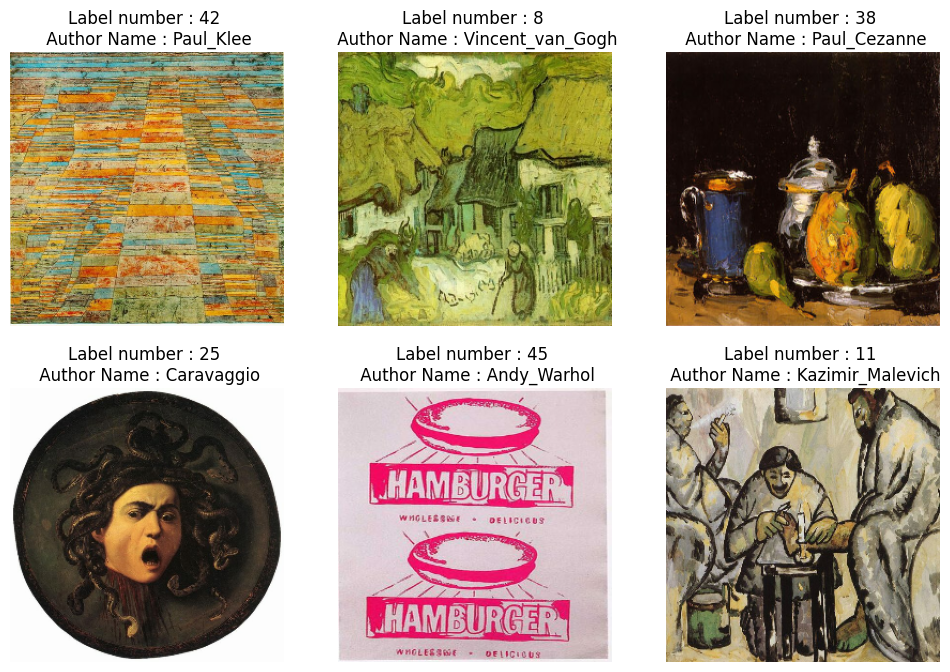

In [ ]:
# 取出 Tensor 圖片來看看
plt.figure(figsize=(12, 8))
for index, (img, label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2, 3, index + 1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(l, rev_class_name[l]))
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [ ]:
# 切割成 training data 與 validation data
train_len = int(0.8 * total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ", train_len, " val size : ", val_len)

# 添加 batch

BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train size :  6016  val size :  1504


In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x, y = trainiter.next()
print("training image batch shape : ", x.shape)
print("training label batch shape : ", y.shape)

training image batch shape :  (32, 256, 256, 3)
training label batch shape :  (32, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做 fine-tuning，**請自己手動建**。

In [ ]:
# 自訂你的model
input_shape=[256,256,3]

model = keras.Sequential(
[
    keras.Input(shape=input_shape),

    keras.layers.Conv2D(32, (3, 3),padding='same',activation='relu', strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, (3, 3),padding='same',activation='relu', strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(256, (3, 3),padding='same',activation='relu', strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(50,activation='softmax')
]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          25,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,291,826 (8.74 MB)

 Trainable params: 2,291,122 (8.74 MB)

 Non-trainable params: 704 (2.75 KB)

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [ ]:

EPOCHS = 50


# model.compile 決定 learning strategy、Loss calculator
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 207ms/step - accuracy: 0.0812 - loss: 5.2003 - val_accuracy: 0.0465 - val_loss: 16.5044
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 207ms/step - accuracy: 0.1399 - loss: 3.5224 - val_accuracy: 0.0904 - val_loss: 13.0368
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.1718 - loss: 3.3368 - val_accuracy: 0.1815 - val_loss: 4.6989
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.1907 - loss: 3.1966 - val_accuracy: 0.2314 - val_loss: 3.0563
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.2074 - loss: 3.1243 - val_accuracy: 0.2247 - val_loss: 3.0632
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - accuracy: 0.1994 - loss: 3.0969 - val_accuracy: 0.2141 - val_loss: 3.0771
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 194ms/step - accuracy: 0.2132 - loss: 2.9753 - val_accuracy: 0.2387 - val_loss: 3.3674
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - accuracy: 0.2343 - loss:

In [ ]:
from keras.models import load_model

In [ ]:
model.save('model.h5')

In [ ]:
import zipfile
import os

# 定義模型檔案和壓縮檔案的名稱
model_filename = 'model.h5'
zip_filename = 'model.zip'

# 創建一個新的 ZIP 檔案並打開
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # 將模型檔案添加到 ZIP 檔案中
    zipf.write(model_filename)

print(f'{model_filename} 已壓縮為 {zip_filename}')

model.h5 已壓縮為 model.zip


In [ ]:
import zipfile
zf=zipfile.ZipFile("model.zip","r")
zf.extractall()  #解壓縮模型zip檔

In [ ]:
model_load=load_model("model.h5")

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
# 載入模型
model_load = tf.keras.models.load_model('model.h5')

# 重新 compile 模型
model_load.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  # 根據你的任務改成正確的 loss
    metrics=['accuracy']
)

# 然後再 fit 模型
history2 = model_load.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 354ms/step - accuracy: 0.5438 - loss: 1.5992 - val_accuracy: 0.4508 - val_loss: 2.3278
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 347ms/step - accuracy: 0.5494 - loss: 1.5485 - val_accuracy: 0.4149 - val_loss: 3.0243
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 336ms/step - accuracy: 0.5452 - loss: 1.5728 - val_accuracy: 0.4681 - val_loss: 2.4977
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.5536 - loss: 1.5203 - val_accuracy: 0.4574 - val_loss: 2.5672
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 340ms/step - accuracy: 0.5641 - loss: 1.5316 - val_accuracy: 0.4621 - val_loss: 2.4561
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 336ms/step - accuracy: 0.5697 - loss: 1.4939 - val_accuracy: 0.4601 - val_loss: 2.4864
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 338ms/step - accuracy: 0.5714 - loss: 1.4820 - val_accuracy: 0.4116 - val_loss: 3.4485
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 338ms/step - accuracy: 0.5692 - loss: 1

## 6. 評估模型

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


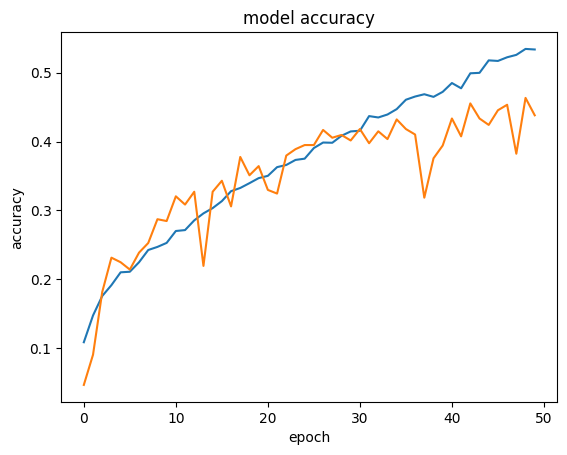

In [ ]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

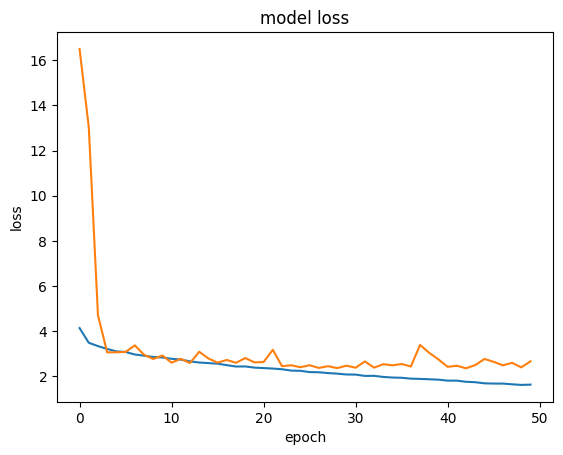

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

In [ ]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(BATCH_SIZE)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4462 - loss: 2.8285
Test loss: 2.6924924850463867
Test accuracy: 0.44191616773605347


## 7. 做預測 
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入 Model 做預測

In [ ]:
A = tf.constant([2, 20, 30, 3, 6])
tf.math.argmax(A)
img = cv.imread('./train_resized/Andy_Warhol_27.jpg')
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
# plt.subplot(4,5,index+1)
# plt.axis("off")
# plt.imshow(img)
img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
img = img / 255.0
authorName = ""
img = tf.expand_dims(img, axis=0)
predictions = model_load.predict(img)
predictions = tf.nn.softmax(predictions)
authorName = tf.argmax(predictions, axis=-1)
print(authorName)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
tf.Tensor([45], shape=(1,), dtype=int64)


In [ ]:
def predict_author(img):
    
    img = tf.expand_dims(img, axis=0)
    predictions = model_load.predict(img)
    predictions = tf.nn.softmax(predictions)
    authorId = tf.argmax(predictions, axis=-1).numpy()[0]
    authorName = rev_class_name[authorId]
    return authorName

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


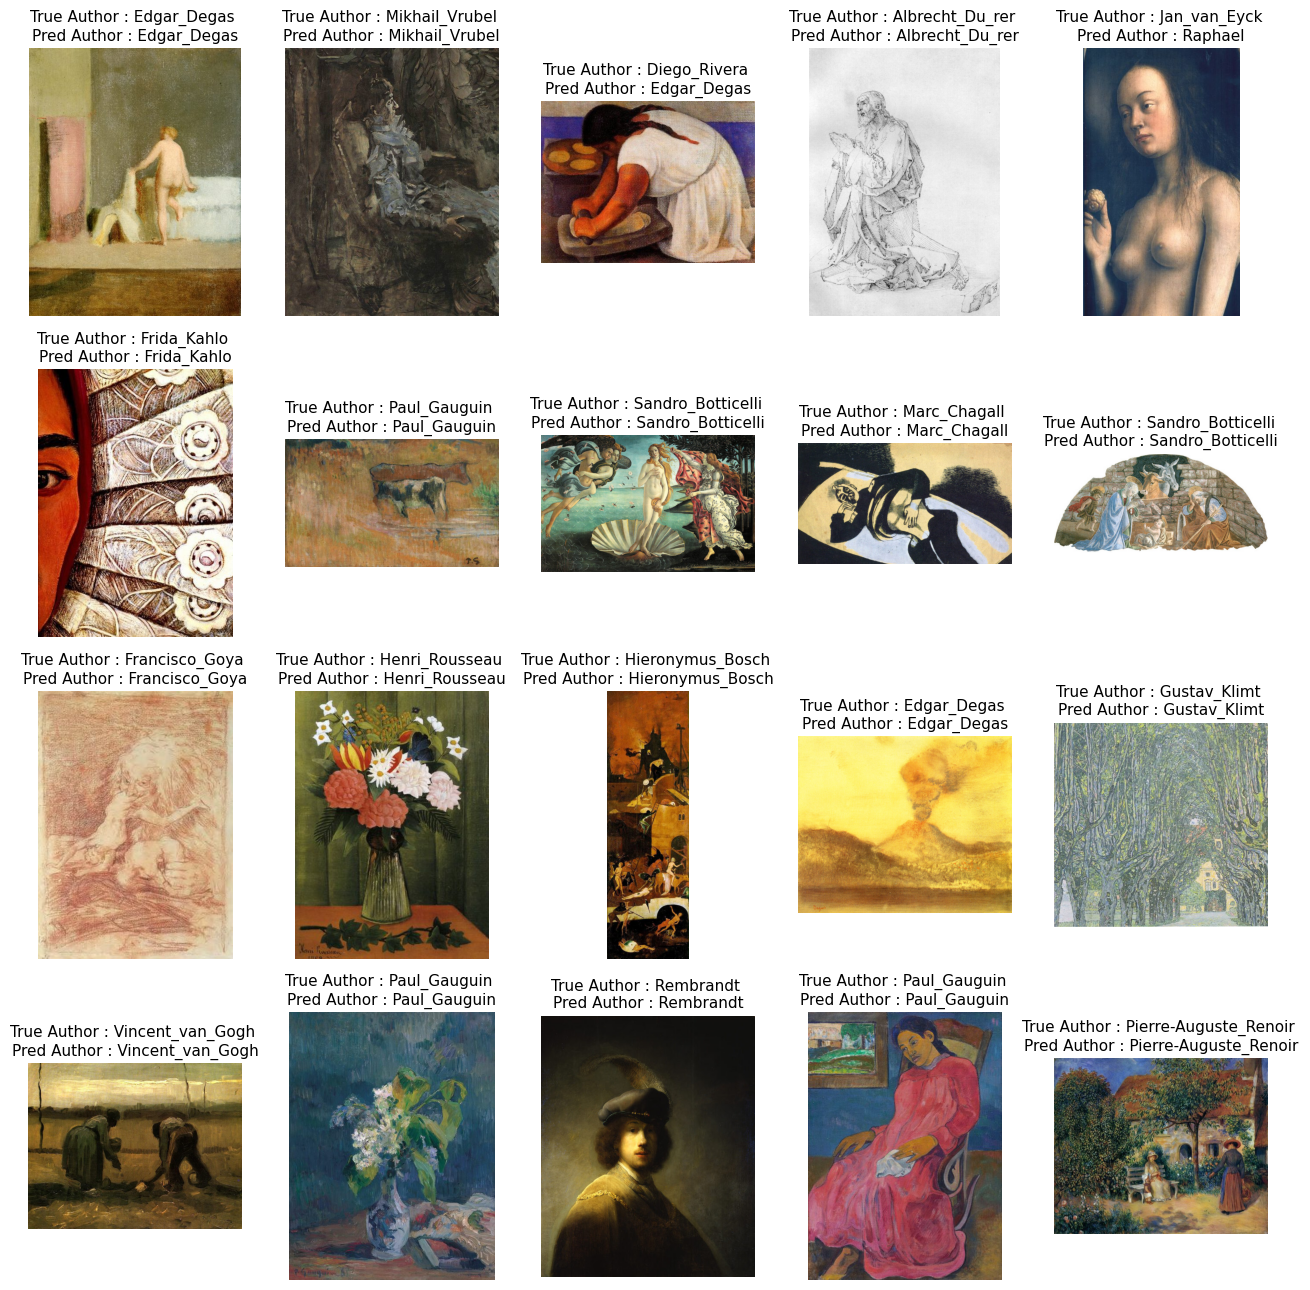

In [ ]:
plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
  imgpath = train_dir+imgName
  img = cv.imread(imgpath)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.subplot(4,5,index+1)
  plt.axis("off")
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img / 255.0
  plt.title("True Author : {} \nPred Author : {}".format("_".join(imgName.split("_")[:-1]),predict_author(img)),size=11)

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

In [ ]:
from google.colab import files


def upload_img():
    uploaded = files.upload()
    img_name = list(uploaded.keys())[0]
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img


def eval():
    img = upload_img()
    plt.title("predict author : {}".format(predict_author(img)))
    plt.axis("off")
    plt.show()

In [ ]:
# 自己上傳一張圖片來試試看
# Demo 圖片來自:
eval()